In [10]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = str(0)

import jax
import jax.numpy as jnp
from jax import vmap, grad, jit
from jax import random

from gpx.models import GPR
from gpx.kernels import se_kernel, grad_kernel

import matplotlib as mpl
import matplotlib.pyplot as plt
plt.style.use('dark_background')

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [11]:
def _func(x):
    """Latent function."""
    return 1.0 * jnp.sin(x * 3 * jnp.pi) + 0.3 * jnp.cos(x * 9 * jnp.pi) + 0.5 * jnp.sin(x * 7 * jnp.pi)

func = vmap(_func)
grad_func = vmap(grad(_func))

# Number of training examples
n = 1000

# Number of inducing variables
m = 30

# Noise
sigma_y = 0.2

# Noisy training data
X = jnp.linspace(-1.0, 1.0, n).reshape(-1, 1)
y = func(X) + sigma_y * random.normal(random.PRNGKey(0), shape=(n, 1))
df = grad_func(X.reshape(-1))
dy = grad_func(X.reshape(-1)).reshape(n, 1) + sigma_y + random.normal(random.PRNGKey(0), shape=(n, 1))

# Test data
X_test = jnp.linspace(-1.5, 1.5, 1000).reshape(-1, 1)
f_true = func(X_test)
df_true = grad_func(X_test.reshape(-1)).reshape(n, 1)

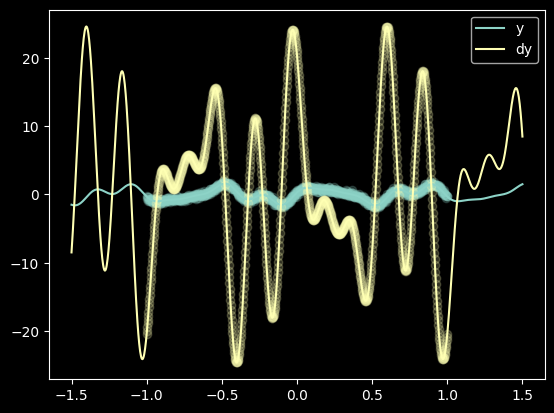

In [12]:
plt.scatter(X, y, alpha=0.2)
plt.plot(X_test, f_true, label='y')

plt.scatter(X, df, alpha=.2)
plt.plot(X_test, df_true, label='dy')

plt.legend()

In [13]:
kernel_params = {'lengthscale': 1.0}
sigma = 1.0

# grad_kernel with argnums = (0, 1) returns a function that computes:
# kernel, derivative kernel on first dimension, derivative kernel on second dimension, and derivative kernel on both dimensions
# here we select the last one (derivatives on both dims)
kernel = lambda x1, x2, params: grad_kernel(se_kernel, argnums=(0, 1))(x1, x2, params)[-1][-1]

In [14]:
model = GPR(kernel, kernel_params, sigma)
model.print()

┌────────────────────┬────────────────────────────────────────────┬─────────┬─────────┬─────────┐
│ name               │ type                                       │ dtype   │ shape   │   value │
├────────────────────┼────────────────────────────────────────────┼─────────┼─────────┼─────────┤
│ kernel lengthscale │ <class 'jaxlib.xla_extension.DeviceArray'> │ float64 │ ()      │       1 │
├────────────────────┼────────────────────────────────────────────┼─────────┼─────────┼─────────┤
│ sigma              │ <class 'jaxlib.xla_extension.DeviceArray'> │ float64 │ ()      │       1 │
└────────────────────┴────────────────────────────────────────────┴─────────┴─────────┴─────────┘


In [15]:
model.fit(X, dy)

In [16]:
model.print()

┌────────────────────┬────────────────────────────────────────────┬─────────┬─────────┬─────────┐
│ name               │ type                                       │ dtype   │ shape   │   value │
├────────────────────┼────────────────────────────────────────────┼─────────┼─────────┼─────────┤
│ kernel lengthscale │ <class 'jaxlib.xla_extension.DeviceArray'> │ float64 │ ()      │ 0.19465 │
├────────────────────┼────────────────────────────────────────────┼─────────┼─────────┼─────────┤
│ sigma              │ <class 'jaxlib.xla_extension.DeviceArray'> │ float64 │ ()      │ 1.2702  │
└────────────────────┴────────────────────────────────────────────┴─────────┴─────────┴─────────┘


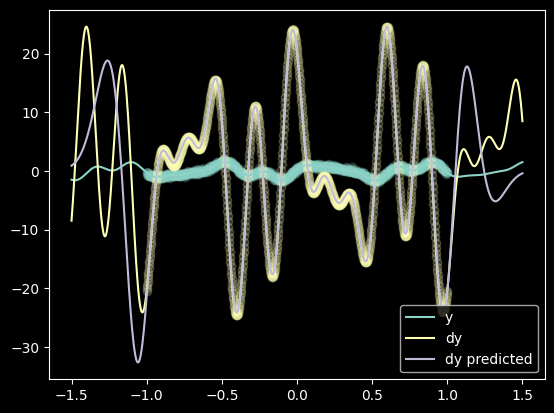

In [20]:
plt.scatter(X, y, alpha=0.2)
plt.plot(X_test, f_true, label='y')

plt.scatter(X, df, alpha=.2)
plt.plot(X_test, df_true, label='dy')

plt.plot(X_test, model.predict(X_test), label='dy predicted')

plt.legend()